# Task 1: CNN image classification

### Import packages

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 
import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.models import Model


## Load the data with ImageDataGenerator

In [8]:

# set the directory based on the folder where you saved dataset
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)    

train_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="training",
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size=(64,64), batch_size=32, shuffle=False)


print(train_data.classes)
print(val_data.classes)
print(train_data.class_indices)
print(test_data.classes)
class_names = np.unique(train_data.classes)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
[0 0 0 ... 5 5 5]
[0 0 0 ... 5 5 5]
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
[0 0 0 ... 5 5 5]


### Plot the class distribution

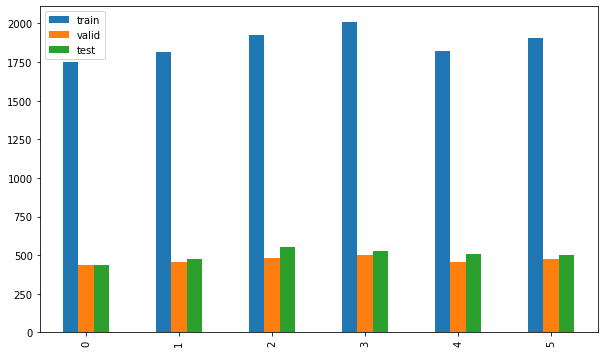

In [3]:

_, train_counts = np.unique(train_data.classes, return_counts=True)
_, val_counts = np.unique(val_data.classes, return_counts=True)
_, test_counts = np.unique(test_data.classes, return_counts=True)
pd.DataFrame({'train': train_counts,
              'valid': val_counts,
              'test': test_counts}, 
             index=class_names
            ).plot.bar(figsize = (10,6))
plt.show()

## Baseline model

In [4]:
# Create Baseline model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras import regularizers
from keras.regularizers import l1,l2

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1, input_shape = (64,64,3)))
model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1))
model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1))
model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
# Flatten the layers
model.add(layers.Flatten())
# Add two dense layers 
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# # Add output layer which uses the softmax activation function, because we are working with multi-class classification. 
model.add(layers.Dense(6, activation='softmax'))
# Compile the model using cross entropy as the loss function (because we are dealing with a classification problem)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-10-09 18:59:44.302333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:59:44.388530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:59:44.389456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:59:44.391512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

### Train baseline model 

In [5]:
# train baseline_model (model_1)
import tensorflow as tf

history = model.fit(train_data, epochs=20, validation_data=val_data, verbose=1)


2022-10-09 19:04:00.320396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-09 19:04:01.936181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 96s 253ms/step - loss: 1.1222 - accuracy: 0.5459 - val_loss: 0.9111 - val_accuracy: 0.6480
Epoch 2/20
351/351 [==============================] - 35s 99ms/step - loss: 0.8566 - accuracy: 0.6783 - val_loss: 0.7819 - val_accuracy: 0.7183
Epoch 3/20
351/351 [==============================] - 35s 100ms/step - loss: 0.7215 - accuracy: 0.7325 - val_loss: 0.7223 - val_accuracy: 0.7340
Epoch 4/20
351/351 [==============================] - 35s 99ms/step - loss: 0.6541 - accuracy: 0.7622 - val_loss: 0.6445 - val_accuracy: 0.7707
Epoch 5/20
351/351 [==============================] - 34s 97ms/step - loss: 0.5918 - accuracy: 0.7850 - val_loss: 0.5606 - val_accuracy: 0.7992
Epoch 6/20
351/351 [==============================] - 34s 98ms/step - loss: 0.5579 - accuracy: 0.7999 - val_loss: 0.5520 - val_accuracy: 0.8110
Epoch 7/20
351/351 [==============================] - 35s 100ms/step - loss: 0.5208 - accuracy: 0.8133 - val_loss: 0.5275 - val_accuracy: 0.8163


### Plot of training and validation curves of baseline model

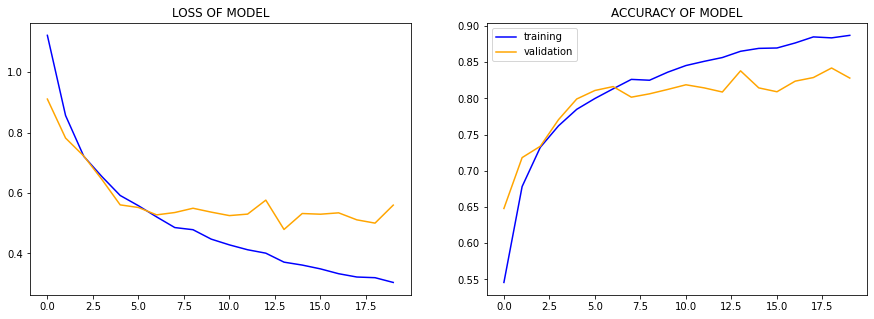

In [6]:
# plot of training and validation curves
def summarize_diagnostics(history):
	# plot loss
	plt.figure(figsize = (15,5))
	plt.subplot(121)
	plt.title('LOSS OF MODEL')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(122)
	plt.title('ACCURACY OF MODEL')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

### Analyze the performance of the baseline model

In [9]:
# change shuffle to False on validation data 
val_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory=train_data_dir,
                                                 shuffle=False,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')

test_pred_1 = model.predict(test_data) # make prediction on test_data
val_pred_1 = model.predict(val_data) # make predicton on validation data

Found 2804 images belonging to 6 classes.


classification_report of validation dataset :

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       438
           1       0.98      0.91      0.94       454
           2       0.82      0.75      0.78       480
           3       0.73      0.87      0.79       502
           4       0.83      0.82      0.83       454
           5       0.87      0.84      0.85       476

    accuracy                           0.83      2804
   macro avg       0.84      0.83      0.84      2804
weighted avg       0.84      0.83      0.83      2804

############################################################
classification_report of test dataset:

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       437
           1       0.97      0.94      0.95       474
           2       0.83      0.74      0.78       553
           3       0.74      0.85      0.79       525
           4       0.81      0.81     

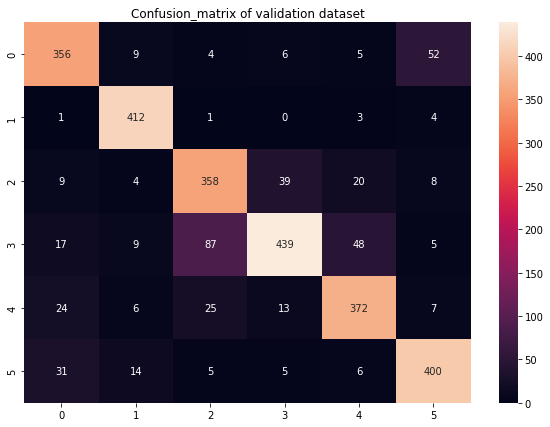

############################################################


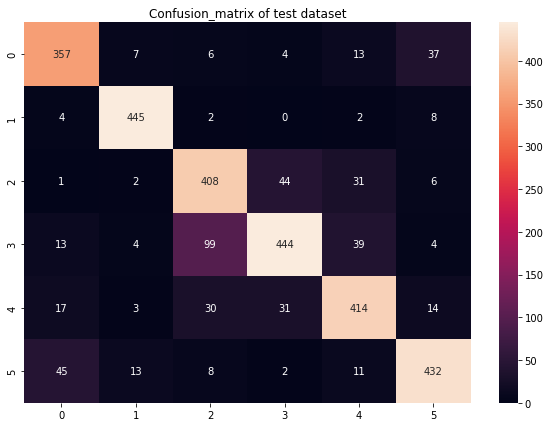

############################################################


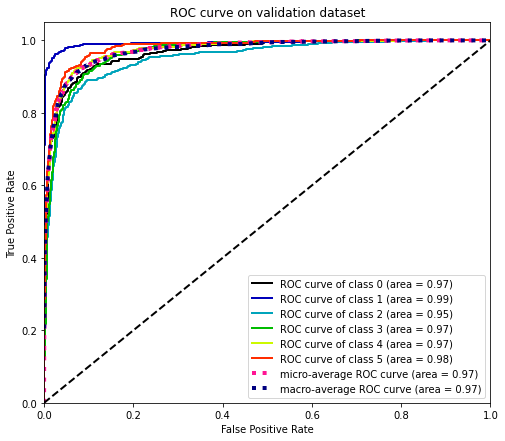

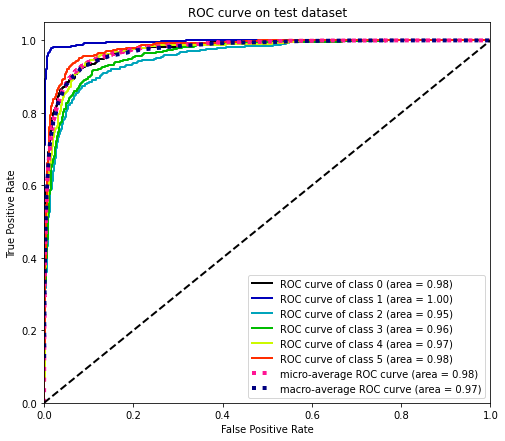

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
import scikitplot as skplt
import seaborn as sns

def metrics(test_pred, test_data, val_pred, val_data):
    
    #################################--Accuracy and AUC score-######################################
    # Classification report validation dataset
    class_report = classification_report(val_data.classes, val_pred.argmax(axis=1))
    print("classification_report of validation dataset :\n")
    print(class_report)
    print("#"*60)
  # Classification report test set
    class_report = classification_report(test_data.classes, test_pred.argmax(axis=1))
    print("classification_report of test dataset:\n")
    print(class_report)
    print("#"*60)
    #################################--Accuracy and AUC score-######################################
       # Accuracy test set 
    acc = accuracy_score(val_pred.argmax(axis=1), val_data.classes)
    print('validation_accuracy: %.3f' % (acc))

      # ROC 
    auc_score = roc_auc_score(val_data.classes, val_pred,  multi_class = 'ovo') 
    print('auc score of validation dataset =',auc_score) 
    print("#"*60)
      # Accuracy test set auc score
    print("#"*60)
    acc = accuracy_score(test_pred.argmax(axis=1), test_data.classes)
    print('test_accuracy: %.3f' % (acc))
    auc_score = roc_auc_score(test_data.classes, test_pred,  multi_class = 'ovo') 
    print('auc score of test dataset =',auc_score) 
    print("#"*60)
    
    ####################################--Confusion matrix --###################################
    # Confusion matrix validation set
    
    plt.figure(figsize = (10,7))
    cm_val = confusion_matrix(val_pred.argmax(axis=1), val_data.classes)
    plt.title("Confusion_matrix of validation dataset")
    sns.heatmap(cm_val, annot = True, fmt='d')
    plt.show()
    print("#"*60)

      # Confusion matrix test set
    plt.figure(figsize = (10,7))
    plt.title ("Confusion_matrix of test dataset")
    cm_test = confusion_matrix(test_pred.argmax(axis=1), test_data.classes)
    sns.heatmap(cm_test, annot = True, fmt='d')
    plt.show()
    print("#"*60)
    ##############################----ROC----#########################################
    skplt.metrics.plot_roc(val_data.classes, val_pred, figsize = (8,7))
    plt.title ("ROC curve on validation dataset")
    plt.show()
    
    skplt.metrics.plot_roc(test_data.classes, test_pred, figsize = (8,7))
    plt.title ("ROC curve on test dataset")
    plt.show()

    return 

metrics(test_pred_1, test_data, val_pred_1, val_data)

## Improved CNN model
- This model is created based on baseline model

In [4]:
# UPDATED MODEL

imp_model = Sequential()
# Add convolutional and pooling layers
imp_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1, input_shape = (64,64,3)))
#imp_model.add(layers.BatchNormalization())
imp_model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
imp_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1))
#imp_model.add(layers.BatchNormalization())
imp_model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
imp_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1))
#imp_model.add(layers.BatchNormalization())
imp_model.add(layers.MaxPooling2D((2, 2), padding="same", strides=2))
# Flatten the layers
imp_model.add(layers.Flatten())
imp_model.add(layers.Dense(32, activation='relu'))
#imp_model.add(layers.BatchNormalization())
imp_model.add(layers.Dropout(0.3))
imp_model.add(layers.Dense(16, activation='relu',
                       activity_regularizer=regularizers.L2(0.01)))
#imp_model.add(layers.BatchNormalization())
#imp_model.add(layers.Dropout(0.3))
          
# # Add output layer which uses the softmax activation function, because we are working with multi-class classification. 
imp_model.add(layers.Dense(6, activation='softmax'))
# Compile the model using cross entropy as the loss function (because we are dealing with a classification problem)
imp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train improved model

In [10]:
# chage to shuffle to True for training 
val_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')

import tensorflow as tf
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose = 1,
                              patience=2, min_lr=0.00001)
history_2 = imp_model.fit(train_data, epochs=35, validation_data=val_data, callbacks=[reduce_lr])

Found 2804 images belonging to 6 classes.
Epoch 1/35
351/351 [==============================] - 34s 96ms/step - loss: 1.4229 - accuracy: 0.4511 - val_loss: 1.1226 - val_accuracy: 0.6102
Epoch 2/35
351/351 [==============================] - 33s 95ms/step - loss: 1.1355 - accuracy: 0.5866 - val_loss: 0.9872 - val_accuracy: 0.6641
Epoch 3/35
351/351 [==============================] - 34s 96ms/step - loss: 1.0206 - accuracy: 0.6350 - val_loss: 0.8788 - val_accuracy: 0.7200
Epoch 4/35
351/351 [==============================] - 33s 95ms/step - loss: 0.9343 - accuracy: 0.6798 - val_loss: 0.8052 - val_accuracy: 0.7454
Epoch 5/35
351/351 [==============================] - 34s 96ms/step - loss: 0.8641 - accuracy: 0.7086 - val_loss: 0.7749 - val_accuracy: 0.7282
Epoch 6/35
351/351 [==============================] - 33s 94ms/step - loss: 0.8095 - accuracy: 0.7265 - val_loss: 0.7174 - val_accuracy: 0.7682
Epoch 7/35
351/351 [==============================] - 34s 97ms/step - loss: 0.7607 - accuracy:

### Plot of training and validation curves of improved model

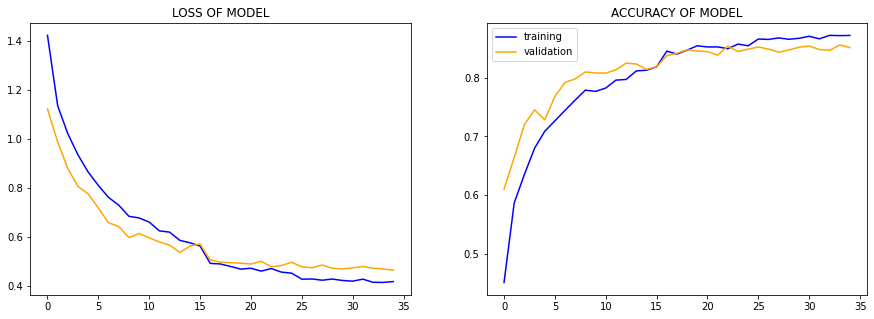

In [11]:
# call the function to plot the loss and accracy 
summarize_diagnostics(history_2)

### Analyze the performance of the improved model

In [12]:
# chage to shuffle to True for training 
val_data = image_generator.flow_from_directory(batch_size=32,
                                                 directory=train_data_dir,
                                                 shuffle=False,
                                                 target_size=(64,64), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_pred_2 = imp_model.predict(test_data)
val_pred_2 = imp_model.predict(val_data) 

Found 2804 images belonging to 6 classes.


classification_report of validation dataset :

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       438
           1       0.96      0.95      0.95       454
           2       0.79      0.80      0.80       480
           3       0.80      0.80      0.80       502
           4       0.85      0.85      0.85       454
           5       0.87      0.88      0.87       476

    accuracy                           0.85      2804
   macro avg       0.85      0.85      0.85      2804
weighted avg       0.85      0.85      0.85      2804

############################################################
classification_report of test dataset:

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       437
           1       0.92      0.98      0.95       474
           2       0.84      0.78      0.81       553
           3       0.80      0.81      0.80       525
           4       0.87      0.86     

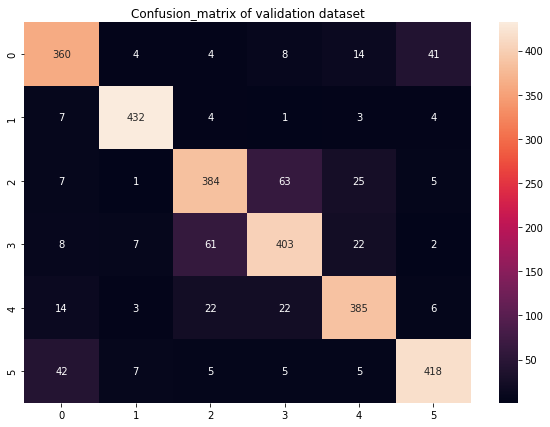

############################################################


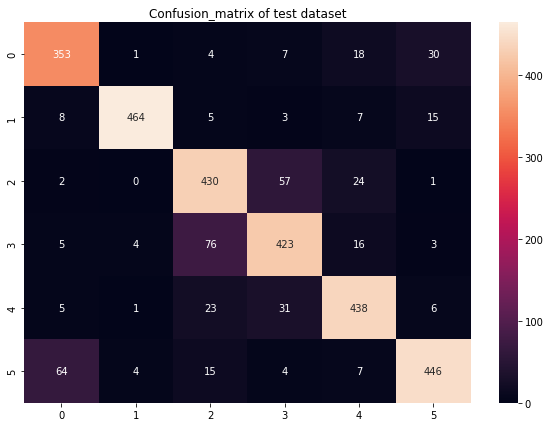

############################################################


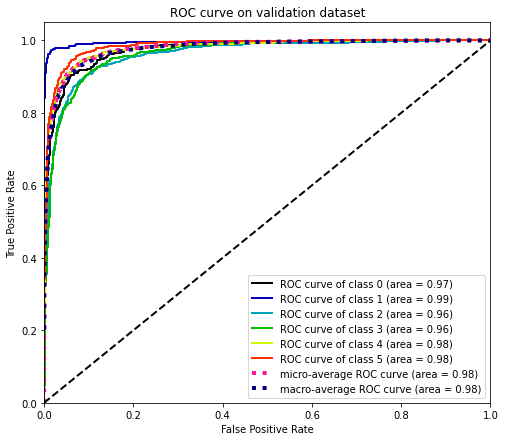

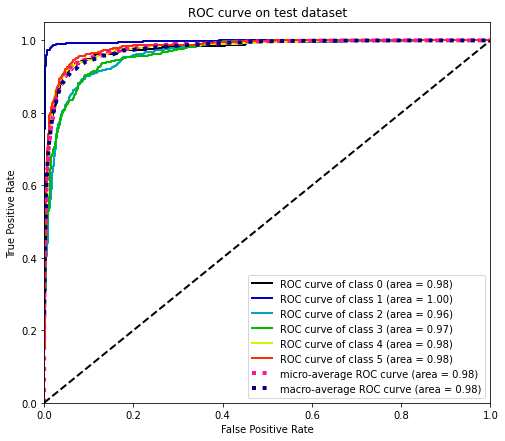

In [13]:
# call the metrics function that is created in previous part. 
metrics(test_pred_2, test_data, val_pred_2, val_data)

## model 3 transfer learning with VGG16

## Load the data and Data augmentation
ImageDataGenerator allow us to use real-time data augmentation 


In [14]:
# set the directory based on the folder where you saved dataset
train_data_dir = '../input/intel-image-classification/seg_train/seg_train' 
test_data_dir = '../input/intel-image-classification/seg_test/seg_test'
#image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) 
image_generator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2], 
                                        validation_split=0.2)

train_data = image_generator.flow_from_directory(batch_size=80,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(150,150), 
                                                 subset="training",
                                                 class_mode='categorical')

val_data = image_generator.flow_from_directory(batch_size=80,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(150,150), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(test_data_dir,
                                       target_size=(150,150), batch_size=80, shuffle=False)
print("data loaded")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
data loaded


### Load the VGG16 model and create final Dense layers

In [15]:
# load VGG16 model
from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(include_top=False, input_shape=(150, 150, 3), weights ='imagenet')

#_______________________________________Dense layers________________________________
NN = layers.Flatten()(vgg16_model.layers[-1].output)
NN = layers.Dropout(0.4)(NN) # 0.1, 0.2, 0.3, 0.4 

#NN = layers.Dense(128, activation='relu')(NN)
#NN = layers.Dense(512, activation='relu')(NN)

#NN = layers.BatchNormalization()(NN)
NN = layers.Dense(128, activation='relu')(NN) #128, 64, 512
output = layers.Dense(6, activation='softmax')(NN)
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=output)
vgg16_model.trainable = True # froze the GG16 layers also Train it vgg16_model.trainable = False 
# summarize
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

### Compile and train VGG16 model 

In [16]:

callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # learning rate [1e-5, 1e-6]
    loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, name='categorical_crossentropy'),
    metrics=[tf.keras.metrics.CategoricalAccuracy(
    name='accuracy')])

history_3 = vgg16_model.fit(train_data, epochs=40, validation_data=val_data, callbacks =[callbacks])

Epoch 1/40
141/141 [==============================] - 113s 761ms/step - loss: 1.0553 - accuracy: 0.5778 - val_loss: 0.5569 - val_accuracy: 0.7939
Epoch 2/40
141/141 [==============================] - 105s 741ms/step - loss: 0.5448 - accuracy: 0.8021 - val_loss: 0.4341 - val_accuracy: 0.8431
Epoch 3/40
141/141 [==============================] - 104s 739ms/step - loss: 0.4408 - accuracy: 0.8427 - val_loss: 0.3776 - val_accuracy: 0.8666
Epoch 4/40
141/141 [==============================] - 105s 746ms/step - loss: 0.3741 - accuracy: 0.8670 - val_loss: 0.3435 - val_accuracy: 0.8787
Epoch 5/40
141/141 [==============================] - 105s 746ms/step - loss: 0.3407 - accuracy: 0.8808 - val_loss: 0.3259 - val_accuracy: 0.8837
Epoch 6/40
141/141 [==============================] - 105s 745ms/step - loss: 0.3198 - accuracy: 0.8845 - val_loss: 0.3118 - val_accuracy: 0.8855
Epoch 7/40
141/141 [==============================] - 105s 745ms/step - loss: 0.3015 - accuracy: 0.8961 - val_loss: 0.2886 -

## Evaluation on validation and test set

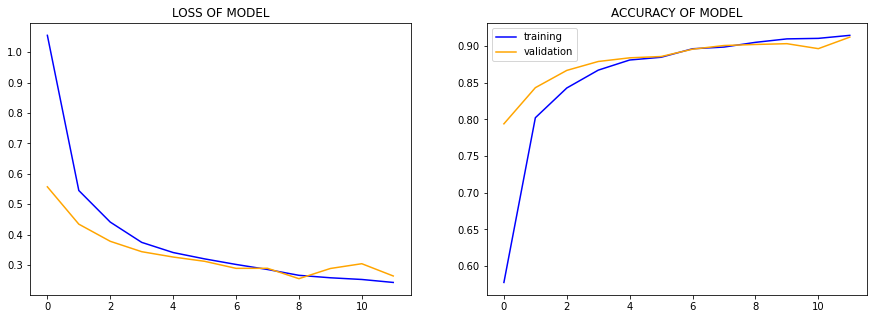

In [17]:
#  the plotting logs 
summarize_diagnostics(history_3)

Found 2804 images belonging to 6 classes.
classification_report of validation dataset :

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       438
           1       0.98      0.98      0.98       454
           2       0.90      0.82      0.86       480
           3       0.86      0.91      0.88       502
           4       0.91      0.94      0.93       454
           5       0.95      0.90      0.92       476

    accuracy                           0.91      2804
   macro avg       0.91      0.91      0.91      2804
weighted avg       0.91      0.91      0.91      2804

############################################################
classification_report of test dataset:

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       437
           1       0.99      0.99      0.99       474
           2       0.88      0.87      0.88       553
           3       0.88      0.88      0.88       

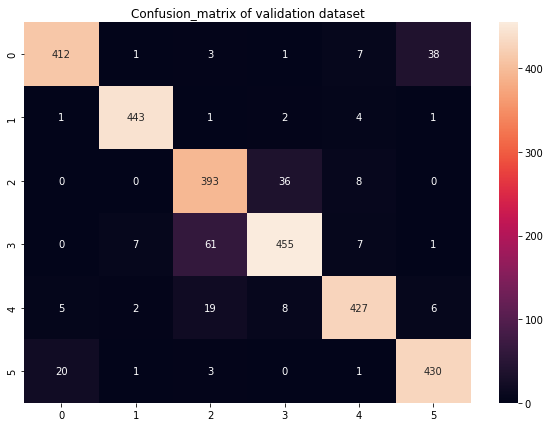

############################################################


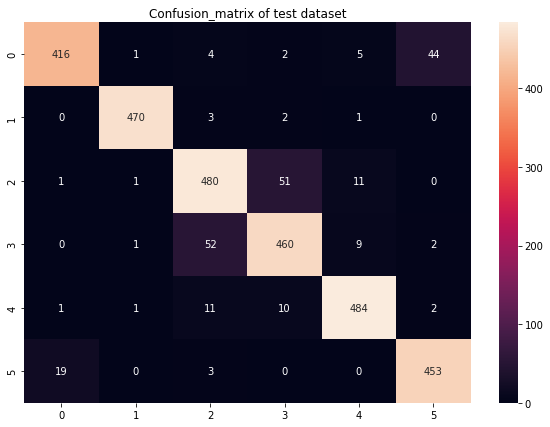

############################################################


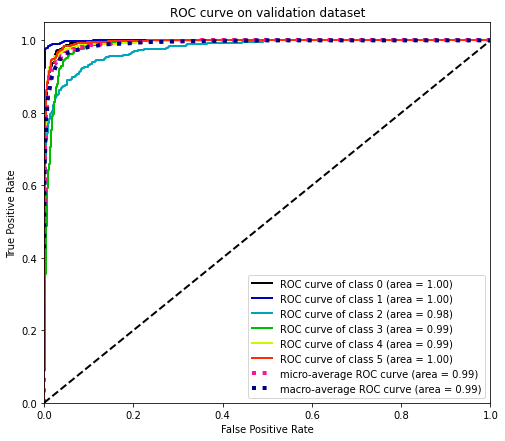

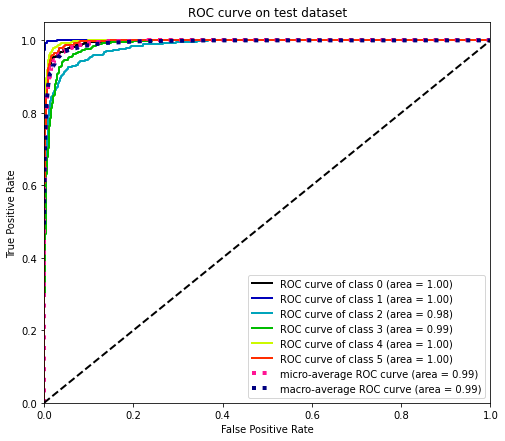

In [18]:
# set the Shuffle False for the validation 
val_data = image_generator.flow_from_directory(batch_size=80,
                                                 directory=train_data_dir,
                                                 shuffle=False,
                                                 target_size=(150,150), 
                                                 subset="validation",
                                                 class_mode='categorical')
test_pred_3 = vgg16_model.predict(test_data) # predicton on test data
val_pred_3 = vgg16_model.predict(val_data) # prediction on validation data

# call the evaluation function that is created in model-1
metrics(test_pred_3, test_data, val_pred_3, val_data)

## Final random prediction with seg_pred dataset 

It is a sea


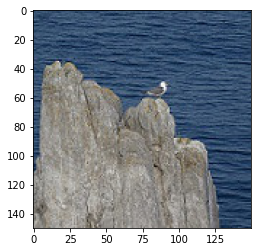

In [19]:
from keras.preprocessing import image
import random 
import glob

# select a random image
path = random.choice(glob.glob("../input/intel-image-classification/seg_pred/seg_pred/*"))

labels = list(train_data.class_indices.keys())

img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

pred = vgg16_model.predict(x)
n = np.argmax(pred) # get index 
print(f"It is a {labels[n]}" )
plt.imshow(img)
plt.show()

## END